In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
tickers = ['ABBV', 'GOOGL', 'JNJ', 'DLTR', 'HLT', 'JPM', 'DEO', 'PG', 'ALB', 'BA', 'NVDA', 'LUV', 'PEP', 'TSM', 'SPY']
raw_data = yf.download(tickers, start='2018-04-20', end='2023-04-20')['Adj Close']
raw_data.head()

[*********************100%%**********************]  15 of 15 completed


,ABBV,ALB,BA,DEO,DLTR,GOOGL,HLT,JNJ,JPM,LUV,NVDA,PEP,PG,SPY,TSM
Date,,,,,,,,,,,,,,,
2018-04-20,71.805351,91.303474,324.343323,121.191719,97.559998,53.866001,80.670456,109.263611,94.603264,52.226273,56.615650,87.399994,63.877060,243.065964,33.190113
2018-04-23,72.247353,90.920532,324.506073,120.716782,97.510002,53.690498,80.435295,109.410294,94.144981,52.426517,55.420017,87.485275,63.184624,243.029556,33.019695
2018-04-24,70.843826,89.463409,315.139832,120.707977,96.519997,51.132000,80.386292,108.858162,93.703674,51.377605,54.756599,86.513023,62.751873,239.756546,33.019695
2018-04-25,71.239296,89.164505,328.356049,121.033394,96.910004,51.149502,80.180527,109.349876,93.347206,51.329933,53.632744,86.265694,62.578754,240.349182,32.525459
2018-04-26,75.558472,90.182625,328.289062,122.387909,96.930000,52.165501,80.278511,110.428207,93.440552,50.824551,55.751717,88.065224,62.968216,242.792480,32.525459


## Data Visualization
### Return data

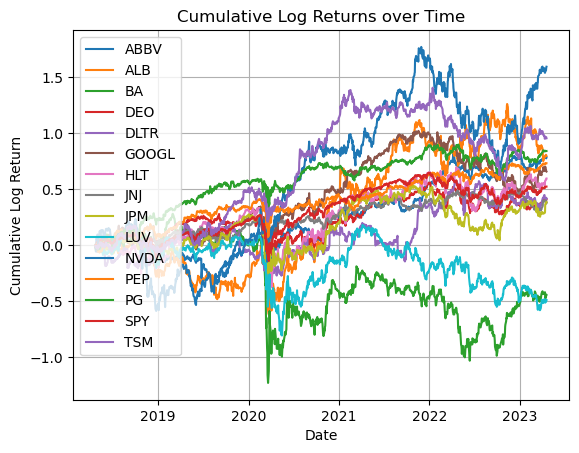

In [29]:
ret = (raw_data - raw_data.shift(1))/ raw_data.shift(1) 
ret = ret.iloc[1:, :]
log_ret = np.log(raw_data / raw_data.shift(1))
cum_log_ret = log_ret.cumsum()
for i in log_ret.columns:
    plt.plot(cum_log_ret[i], label=i)
plt.title('Cumulative Log Returns over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()    

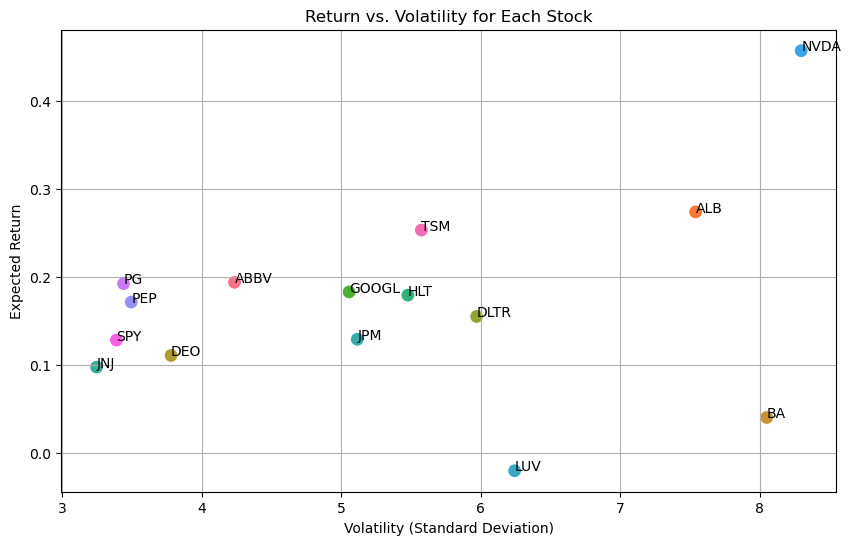

In [4]:
expected_returns = ret.mean() * 252
volatilities = ret.std() * 252
# Scatter chart for return vs. volatility
plt.figure(figsize=(10, 6))
sns.scatterplot(x=volatilities, y=expected_returns, hue=expected_returns.index, s=100, legend=None)
plt.title('Return vs. Volatility for Each Stock')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
for i, ticker in enumerate(expected_returns.index):
    plt.annotate(ticker, (volatilities[i], expected_returns[i]))

plt.grid(True)
plt.show()

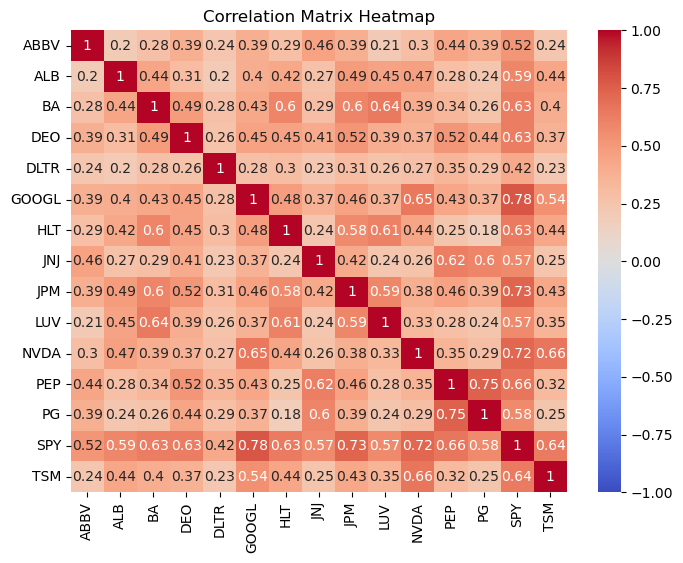

In [5]:
correlation_matrix = ret.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Global Min Variance

In [6]:
covar = ret.cov()
r = np.mean(ret,axis=0)*252


# r is each stock's return, w is the portion of each stock in our portfolio, and covar is the covariance matrix
# Rate of return
def ret_vector(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret_vector,vol):
    return ret_vector/vol

# The first boundary is the short sell limit
from scipy.optimize import Bounds
bounds = Bounds(0, 1)
# The second boundary is the sum of weights.
from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint(np.ones((ret.shape[1],), dtype=int),1,1)

# Find a portfolio with the minimum risk.
from scipy.optimize import minimize
#Create x0, the first guess at the values of each stock's weight.
weights = np.ones(ret.shape[1])
x0 = weights/np.sum(weights)
#Define a function to calculate volatility
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

np.set_printoptions(suppress = True, precision=2)
for ticker, weight in zip(tickers, w_min):
    print(f"{ticker}: {weight:.4f}")
print('return: % .2f'% (ret_vector(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar))

ABBV: 0.1038
GOOGL: 0.0001
JNJ: 0.0000
DLTR: 0.1661
HLT: 0.0523
JPM: 0.0001
DEO: 0.0525
PG: 0.3316
ALB: 0.0000
BA: 0.0016
NVDA: 0.0000
LUV: 0.0124
PEP: 0.2272
TSM: 0.0002
SPY: 0.0521
return:  14.76 risk:  0.011


In [7]:
#Define 1/Sharpe_ratio
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
w_sharpe = res_sharpe.x
for ticker, weight in zip(tickers, w_sharpe):
    print(f"{ticker}: {weight:.4f}")
print('return: % .2f'% (ret_vector(r,w_sharpe)*100), 'risk: % .3f'% vol(w_sharpe,covar))

ABBV: 0.2163
GOOGL: 0.0351
JNJ: 0.0000
DLTR: 0.0000
HLT: 0.0000
JPM: 0.0000
DEO: 0.0094
PG: 0.0000
ALB: 0.0000
BA: 0.0000
NVDA: 0.1661
LUV: 0.0000
PEP: 0.4905
TSM: 0.0000
SPY: 0.0823
return:  24.46 risk:  0.013


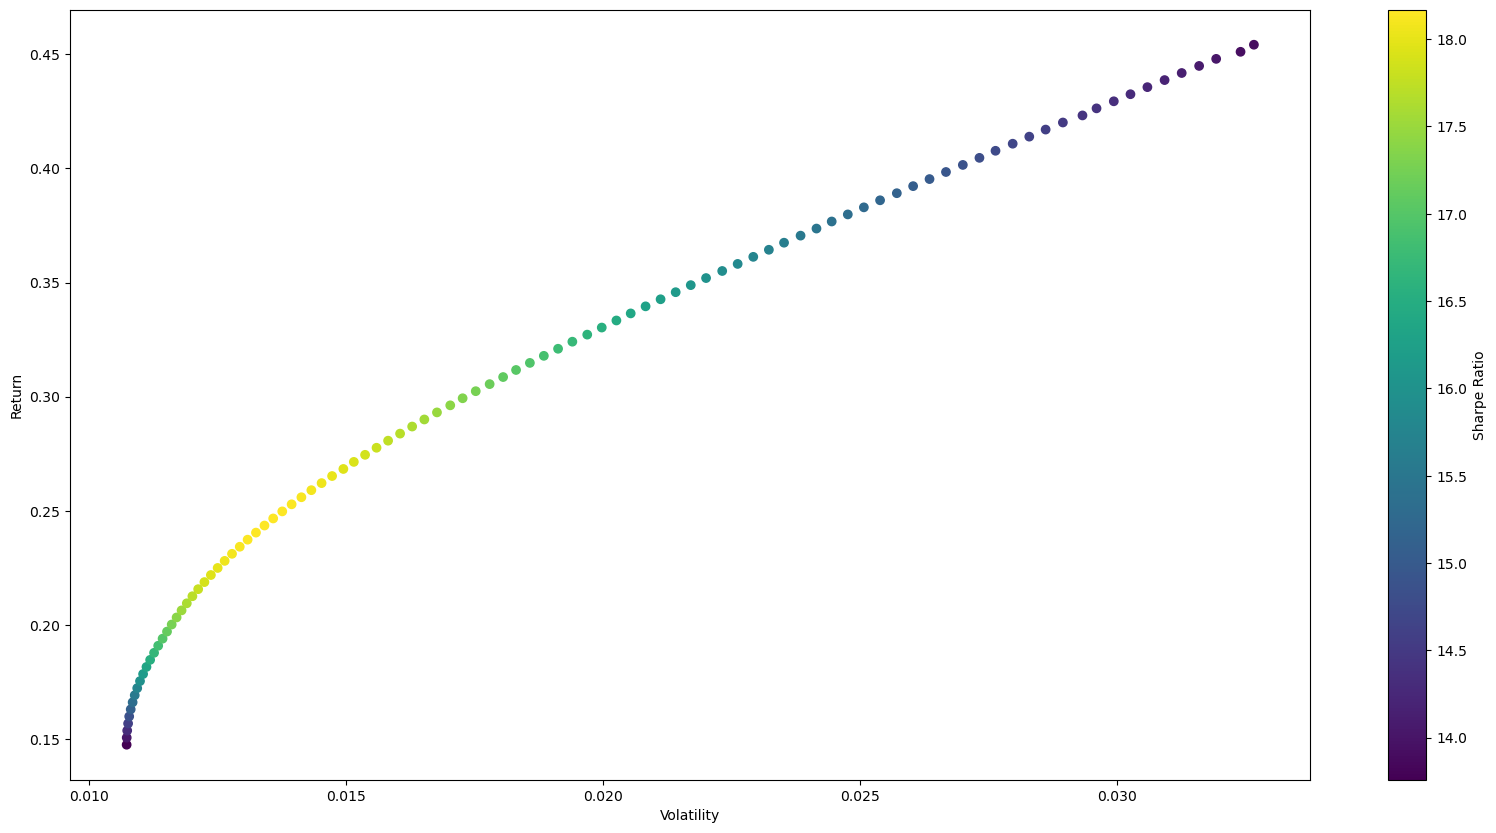

In [8]:
w = w_min
num_ports = 100
gap = (np.amax(r) - ret_vector(r,w_min))/num_ports


all_weights = np.zeros((num_ports, len(ret.columns)))
all_weights[0],all_weights[1]=w_min,w_sharpe
ret_arr = np.zeros(num_ports)
ret_arr[0],ret_arr[1]=ret_vector(r,w_min),ret_vector(r,w_sharpe)
vol_arr = np.zeros(num_ports)
vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)

for i in range(num_ports):
    port_ret = ret_vector(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(ret.shape[1]),r],[1,port_ret],[1,port_ret])
    
    #Create x0: initial guesses for weights.
    x0 = w_min
    #Define a function for portfolio volatility.
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)
    
    all_weights[i,:]=a.x
    ret_arr[i]=port_ret
    vol_arr[i]=vol(a.x,covar)
    
sharpe_arr = ret_arr/vol_arr  

plt.figure(figsize=(20,10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [9]:
data = {
    "Portfolio": [f"Portfolio {i+1}" for i in range(num_ports)],
    "Return": ret_arr,
    "Volatility": vol_arr,
    "Sharpe Ratio": sharpe_arr
}

# Add weights for each ticker
for idx, ticker in enumerate(tickers):
    data[ticker + " Weight"] = all_weights[:, idx]

portfolio_df = pd.DataFrame(data)

# Display the DataFrame
portfolio_df

,Portfolio,Return,Volatility,Sharpe Ratio,ABBV Weight,GOOGL Weight,JNJ Weight,DLTR Weight,HLT Weight,JPM Weight,DEO Weight,PG Weight,ALB Weight,BA Weight,NVDA Weight,LUV Weight,PEP Weight,TSM Weight,SPY Weight
0,Portfolio 1,0.147559,0.010724,13.759284,0.104129,0.000208,0.000051,0.164923,0.052116,0.000319,0.051868,0.329947,0.000148,0.002609,0.000053,0.014049,0.226836,0.000683,0.052063
1,Portfolio 2,0.150656,0.010726,14.046089,0.109847,0.000055,0.000010,0.156489,0.051024,0.000068,0.055059,0.313770,0.000031,0.000163,0.000012,0.015554,0.239984,0.000132,0.057803
2,Portfolio 3,0.153754,0.010735,14.322296,0.116546,0.000046,0.000012,0.145748,0.049698,0.000066,0.056764,0.294210,0.000034,0.000087,0.000012,0.018988,0.253645,0.000082,0.064061
3,Portfolio 4,0.156851,0.010753,14.587032,0.123111,0.000351,0.000044,0.134583,0.048144,0.000297,0.058293,0.274147,0.000131,0.000217,0.000068,0.023806,0.266512,0.000388,0.069907
4,Portfolio 5,0.159948,0.010774,14.845631,0.129917,0.000097,0.000008,0.124102,0.046800,0.000060,0.060261,0.254993,0.000026,0.000031,0.000016,0.026110,0.281063,0.000067,0.076448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Portfolio 96,0.441795,0.031260,14.132826,0.003507,0.001346,0.000059,0.000082,0.000262,0.000134,0.000126,0.000157,0.000085,0.000032,0.941268,0.000408,0.052042,0.000130,0.000362
96,Portfolio 97,0.444892,0.031599,14.079117,0.003204,0.000286,0.000070,0.000112,0.000180,0.000166,0.000340,0.000239,0.000037,0.000082,0.953322,0.000486,0.040666,0.000175,0.000636
97,Portfolio 98,0.447990,0.031931,14.029836,0.002451,0.001354,0.000046,0.000155,0.000168,0.000144,0.000202,0.000145,0.000119,0.000059,0.964696,0.000363,0.029699,0.000087,0.000312
98,Portfolio 99,0.451087,0.032406,13.920068,0.001816,0.002668,0.000938,0.001243,0.001476,0.001565,0.001597,0.001205,0.001308,0.000822,0.978359,0.001622,0.001822,0.001282,0.002277


### Histroical Simulation VaR

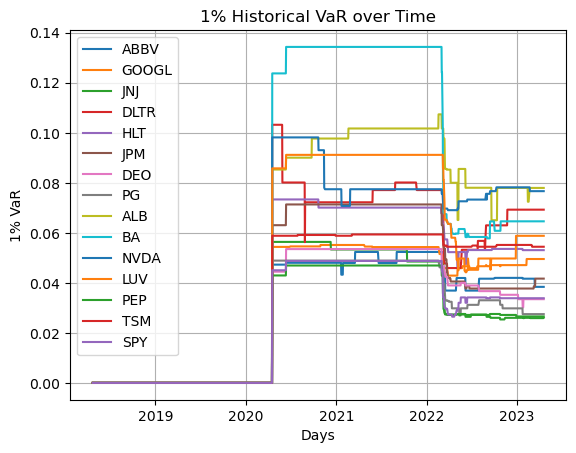

In [10]:
window_length = 500
hs_var = np.zeros([len(ret), len(tickers)])

# Calculate the hs_var for each ticker and each day
for i in range(window_length, len(ret)):
    for ticker_idx, ticker in enumerate(tickers):
        ret_window = ret[ticker][i - window_length:i]
        hs_var[i][ticker_idx] = np.percentile(ret_window, 1)

# Plotting
for ticker_idx, ticker in enumerate(tickers):
    plt.plot(ret.index,-hs_var[:, ticker_idx], label=ticker)

plt.legend(loc='upper left')
plt.title('1% Historical VaR over Time')
plt.xlabel('Days')
plt.ylabel('1% VaR')
plt.grid(True)
plt.show()

### Parameters VaR

In [25]:
# Parameters
lambda_ = 0.94
from scipy.stats import norm

# Calculate z_1_percent using scipy's norm.ppf function
z_1_percent = -norm.ppf(0.01)  # 1% quantile of the standard normal distribution

# Initialize sigma_squared with zeros for all days and tickers
sigma_squared = np.zeros((len(ret), len(tickers)))

# Calculate VaR
param_var = np.zeros_like(sigma_squared)

# Loop through each ticker
for ticker_idx, ticker in enumerate(tickers):
    # Initialize the first value of sigma_squared using the variance of the first 100 returns
    sigma_squared[0, ticker_idx] = ret[ticker][:100].var()
    
    # Calculate sigma_squared for each day using the EWMA model
    for t in range(1, len(ret)):
        sigma_squared[t, ticker_idx] = (lambda_ * ret[ticker][t-1]**2 + (1 - lambda_) * sigma_squared[t-1, ticker_idx])
    
    # Calculate 1% VaR using the computed sigma_squared values
    param_var[:, ticker_idx] = -z_1_percent * np.sqrt(sigma_squared[:, ticker_idx])

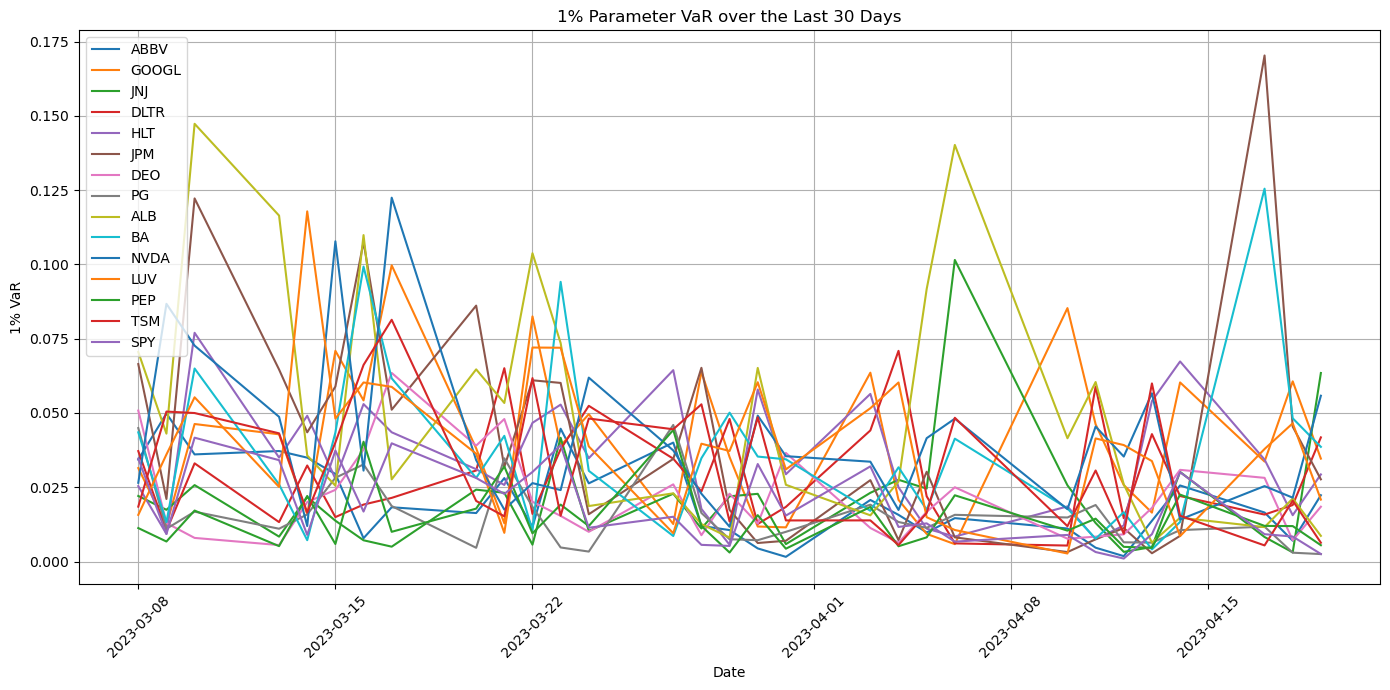

In [12]:
last_30_days_var = param_var[-30:]
last_30_days_dates = ret.index[-30:]

plt.figure(figsize=(14, 7))
for ticker_idx, ticker in enumerate(tickers):
    plt.plot(last_30_days_dates, -last_30_days_var[:, ticker_idx], label=ticker)

plt.legend(loc='upper left')
plt.title('1% Parameter VaR over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('1% VaR')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()

### Garch(1,1) VaR

In [30]:
from arch import arch_model

# Placeholder for VaR values
garch_var = np.zeros([len(ret), len(tickers)])

for ticker_idx, ticker in enumerate(tickers):
    # Fit GARCH(1,1) model
    model = arch_model(ret[ticker] * 100, vol='Garch', p=1, q=1)
    results = model.fit(disp='off')  # disp='off' suppresses convergence output
    
    # Forecast next period volatility
    forecasts = results.forecast(start=0)
    forecasted_volatility = forecasts.variance.values[:, -1] ** 0.5
    
    # Calculate 1% VaR
    garch_var[:, ticker_idx] = -z_1_percent * forecasted_volatility

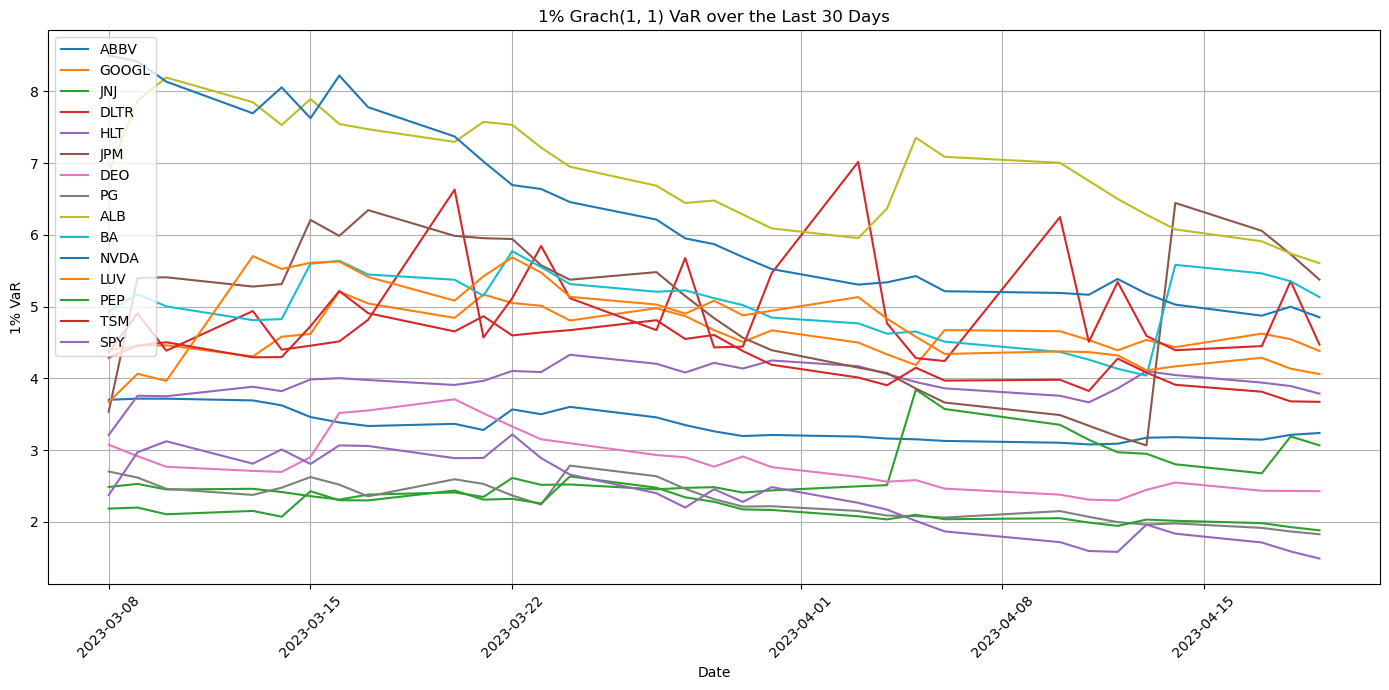

In [31]:
last_30_days_var = garch_var[-30:]
last_30_days_dates = ret.index[-30:]

plt.figure(figsize=(14, 7))
for ticker_idx, ticker in enumerate(tickers):
    plt.plot(last_30_days_dates, -last_30_days_var[:, ticker_idx], label=ticker)

plt.legend(loc='upper left')
plt.title('1% Grach(1, 1) VaR over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('1% VaR')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()

### FHS VaR

In [32]:
# Initialize var_fhs with zeros
var_fhs = np.zeros_like(ret.values)

# Loop through each ticker
for ticker_idx, ticker in enumerate(tickers):
    for i in range(500, len(ret)):
        # Get window of past 500 days' returns
        ret_window = ret[ticker].iloc[i - 500:i] *100

        # Fit GARCH(1,1) model
        garch = arch_model(ret_window, vol='Garch', p=1, q=1).fit(disp='off')
        
        # Forecast next day's volatility
        omega, alpha, beta = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
        sigma = np.sqrt(omega + alpha * ret_window.iloc[-1] ** 2 + beta * garch.conditional_volatility[-1] ** 2)

        # Filtered Historical Simulation
        standardized_returns = ret_window / garch.conditional_volatility
        var_fhs[i, ticker_idx] = sigma * np.percentile(standardized_returns, 1)

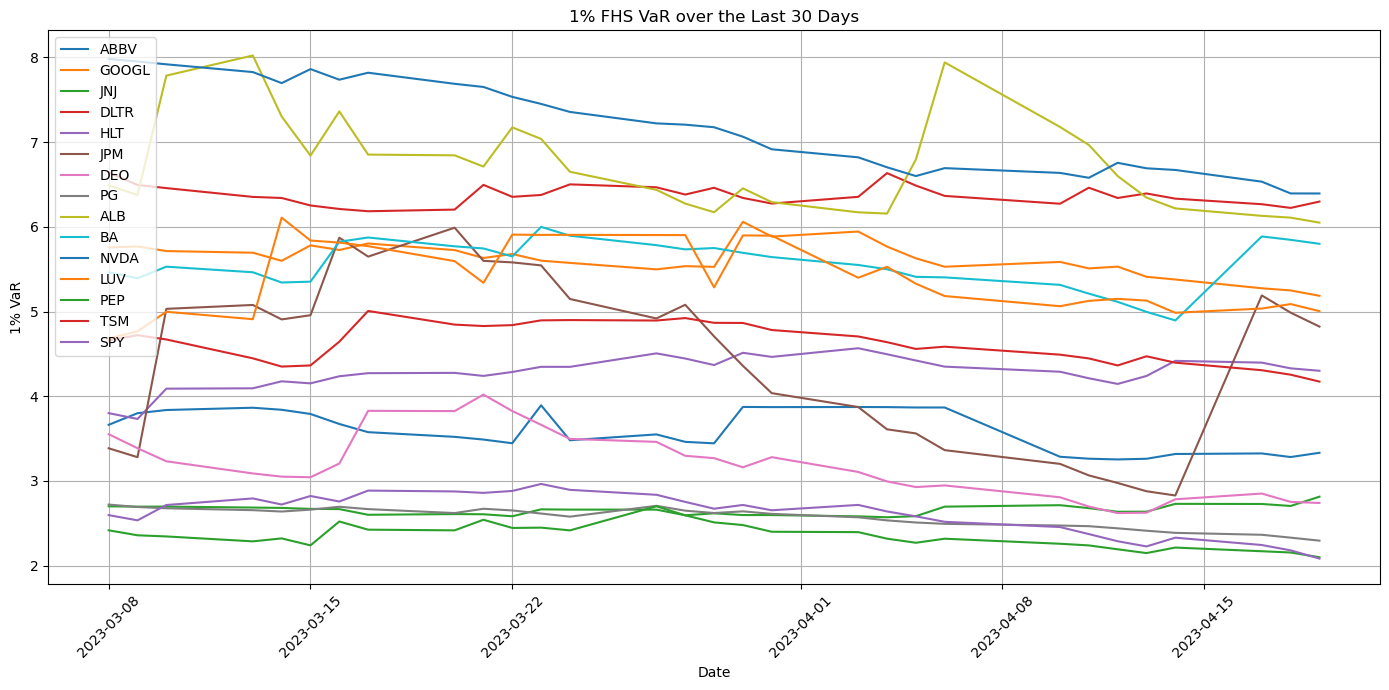

In [33]:
last_30_days_var = var_fhs[-30:]
last_30_days_dates = ret.index[-30:]

plt.figure(figsize=(14, 7))
for ticker_idx, ticker in enumerate(tickers):
    plt.plot(last_30_days_dates, -last_30_days_var[:, ticker_idx], label=ticker)

plt.legend(loc='upper left')
plt.title('1% FHS VaR over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('1% VaR')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()

### Monte Carlo & FHS for term structure VaR and ES

In [36]:
from arch import arch_model

# GARCH(1,1) model fitting for each ticker
var_results = {}
es_results = {}

for ticker in tickers:
    ret_ticker = ret[ticker] * 100
    garch = arch_model(ret_ticker, vol='Garch', p=1, q=1).fit(disp='off')
    omega, alpha, beta = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    sigma = garch.conditional_volatility
    Retstand = ret_ticker / sigma
    sigmapred = np.sqrt(omega + alpha * ret_ticker.iloc[-1]**2 + beta * sigma.iloc[-1]**2)

    # Monte Carlo simulation
    MC = 10000
    T = 100
    shock = np.random.choice(Retstand, size=(MC, T))
    ReturnMC = np.zeros((MC, T))

    sigmapredMC = sigmapred
    for i in range(MC):
        for j in range(T):
            ReturnMC[i, j] = sigmapredMC * shock[i, j]
            sigmapredMC = np.sqrt(omega + alpha * ReturnMC[i, j]**2 + beta * sigmapredMC**2)

    ReturnMCT = np.cumsum(ReturnMC, axis=1)

    # Calculate VaR
    VaRMC = -np.percentile(ReturnMCT, 1, axis=0)
    var_results[ticker] = VaRMC

    # Calculate Expected Shortfall (ES)
    ESMC = []
    for i in range(T):
        threshold = -VaRMC[i]
        ESMC.append(-np.mean(ReturnMCT[ReturnMCT[:, i] <= threshold, i]))
    es_results[ticker] = ESMC

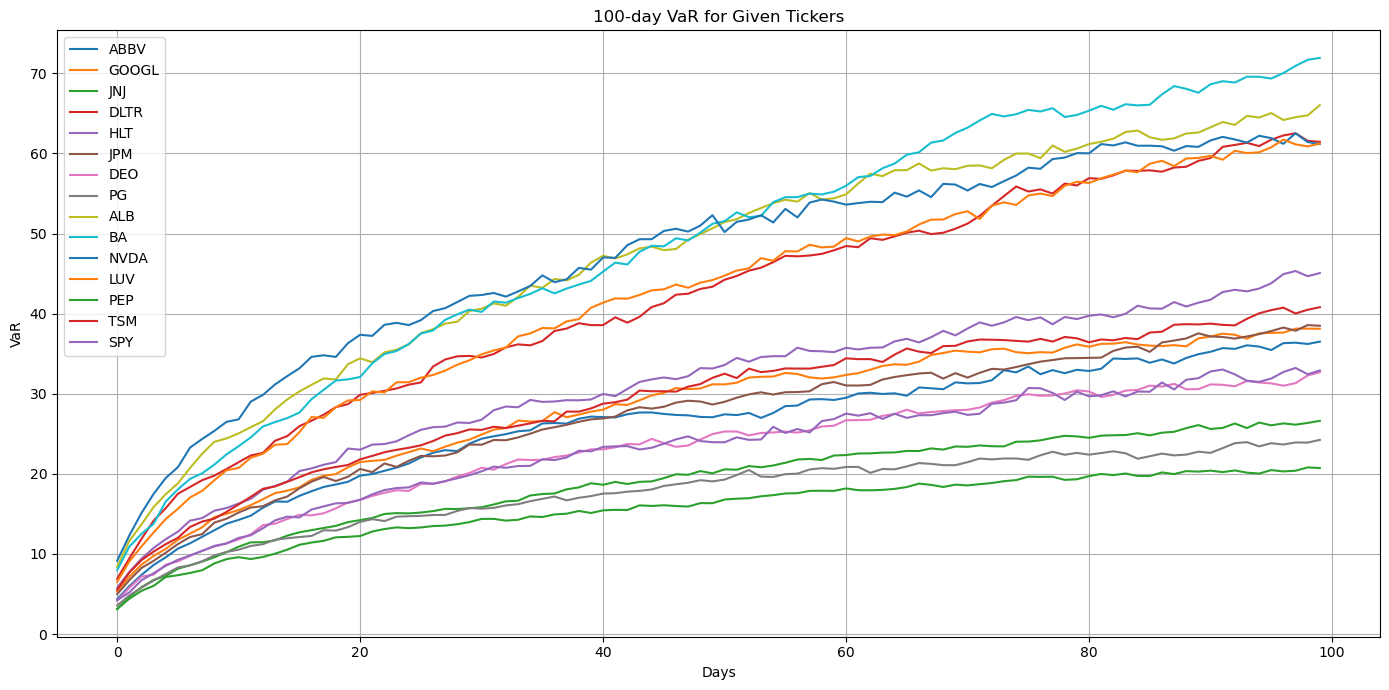

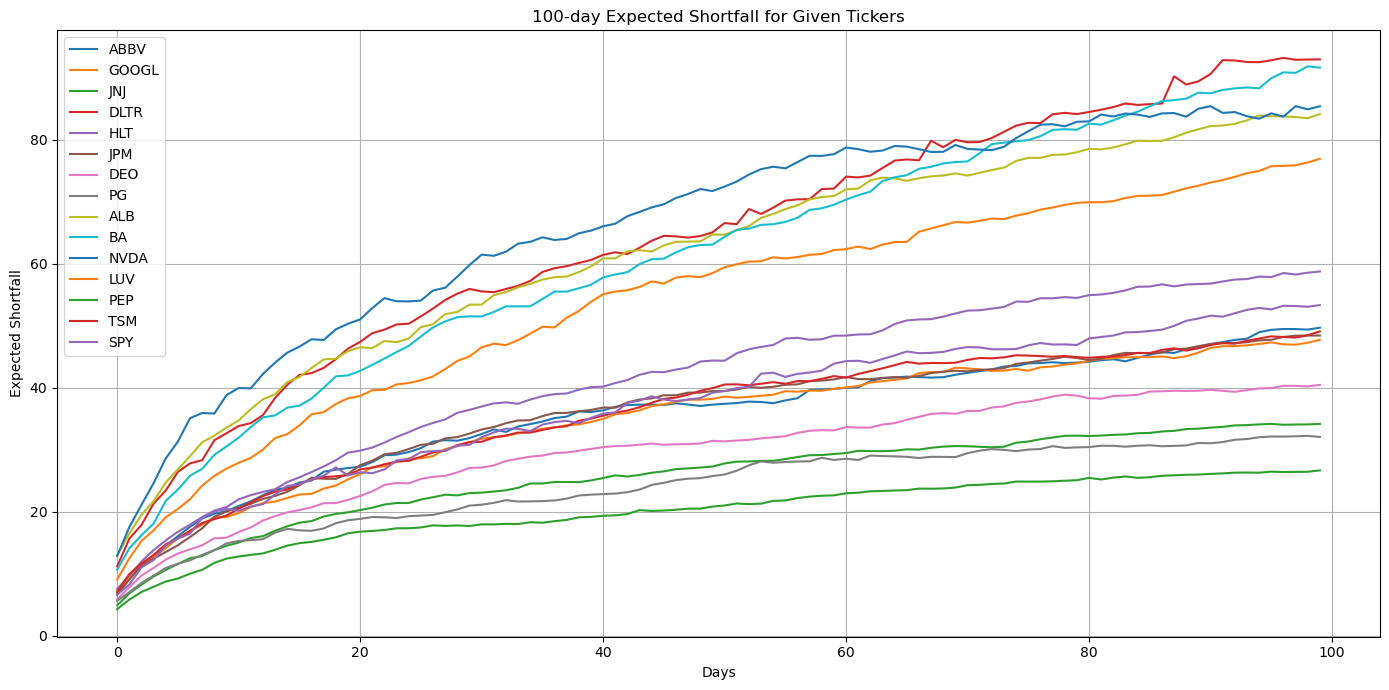

In [38]:
# Plotting VaR for all tickers
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(var_results[ticker], label=ticker)
plt.title('100-day VaR for Given Tickers')
plt.xlabel('Days')
plt.ylabel('VaR')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting ES for all tickers
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(es_results[ticker], label=ticker)
plt.title('100-day Expected Shortfall for Given Tickers')
plt.xlabel('Days')
plt.ylabel('Expected Shortfall')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()